# Titanic Survival Prediction with Logistic Regression

**In this lecture, we’ll work with the famous Titanic dataset from Kaggle. This dataset is often used as a beginner-friendly project to practice data cleaning, exploratory analysis, and predictive modeling.**

**Our main task is to predict whether a passenger survived or not using Logistic Regression, one of the fundamental algorithms for binary classification.**

## 1. Importing Libraries and Loading Data

In [86]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display plots inside the notebook
%matplotlib inline


In [87]:
# Load  dataset
df = pd.read_csv("titanic.csv")

# Take a quick look at the first rows
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Exploratory Data Analysis (EDA)
**Before modeling, we need to understand our data. We’ll check for missing values, study distributions, and look for relationships between features and survival.**

### 2.1 Checking for Missing Data

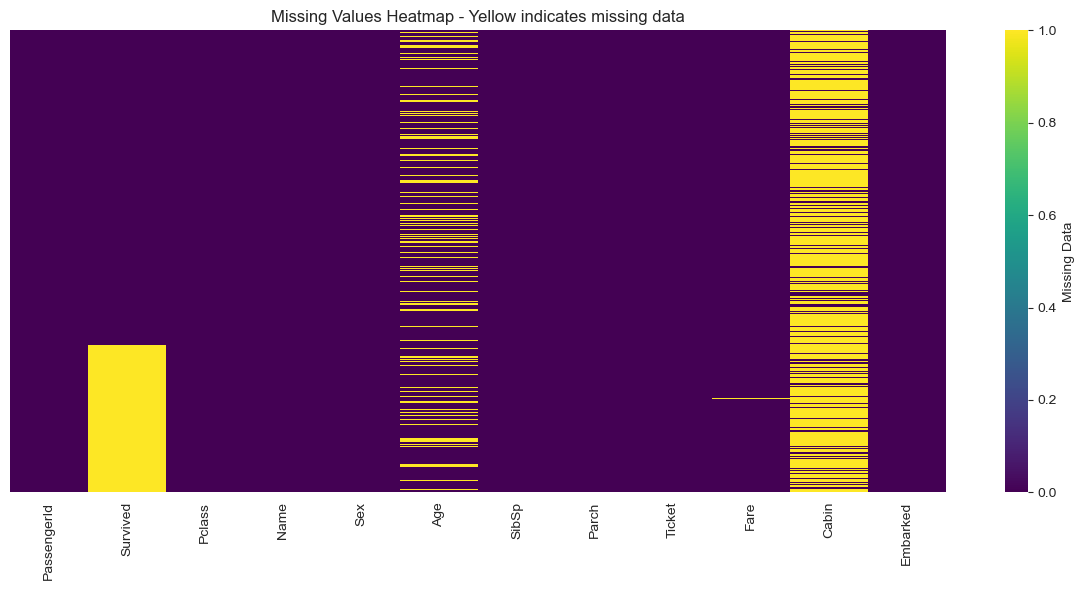

In [88]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(df.isnull(), 
            yticklabels=False,
            cbar=True,
            cmap="viridis",
            cbar_kws={'label': 'Missing Data'},
            ax=ax) 

ax.set_title('Missing Values Heatmap - Yellow indicates missing data')
plt.tight_layout()
plt.show()

**Observations:**

- About 20% of Age values are missing. This is manageable with imputation.

- Cabin has too many missing entries to be useful directly. We may drop it or engineer a simpler feature (e.g., “Cabin Known: Yes/No”).

- A few missing values exist in Embarked.

## 2.2 Visualizing Distributions

/var/folders/7s/0rcqb3qx23q58vkkkt44m9hc0000gn/T/ipykernel_7275/3907021261.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Survived", data=df, palette="RdBu_r", ax=axes[0])


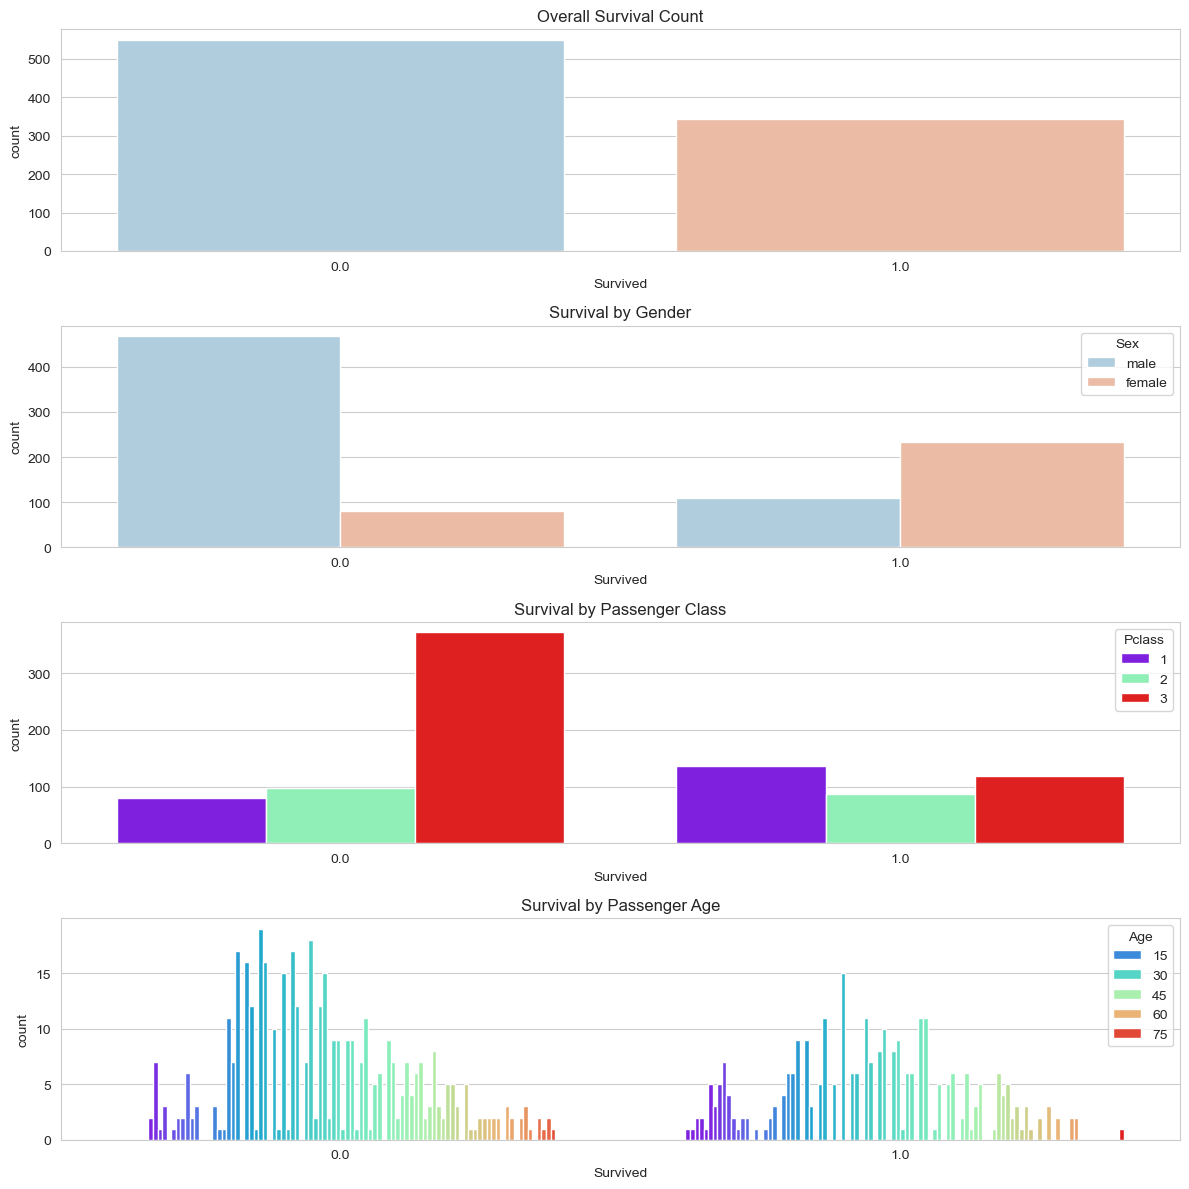

In [89]:
# Create a figure with subplots
fig, axes = plt.subplots(4,1, figsize=(12,12))

# Plot 1: Overall survival
sns.countplot(x="Survived", data=df, palette="RdBu_r", ax=axes[0])
axes[0].set_title('Overall Survival Count')

# Plot 2: Survival by gender
sns.countplot(x="Survived", hue="Sex", data=df, palette="RdBu_r", ax=axes[1])
axes[1].set_title('Survival by Gender')

# Plot 3: Survival by passenger class
sns.countplot(x="Survived", hue="Pclass", data=df, palette="rainbow", ax=axes[2])
axes[2].set_title('Survival by Passenger Class')

# Plot 4: Survival by passenger Age
sns.countplot(x="Survived", hue="Age", data=df, palette="rainbow", ax=axes[3])
axes[3].set_title('Survival by Passenger Age')

plt.tight_layout()
plt.show()

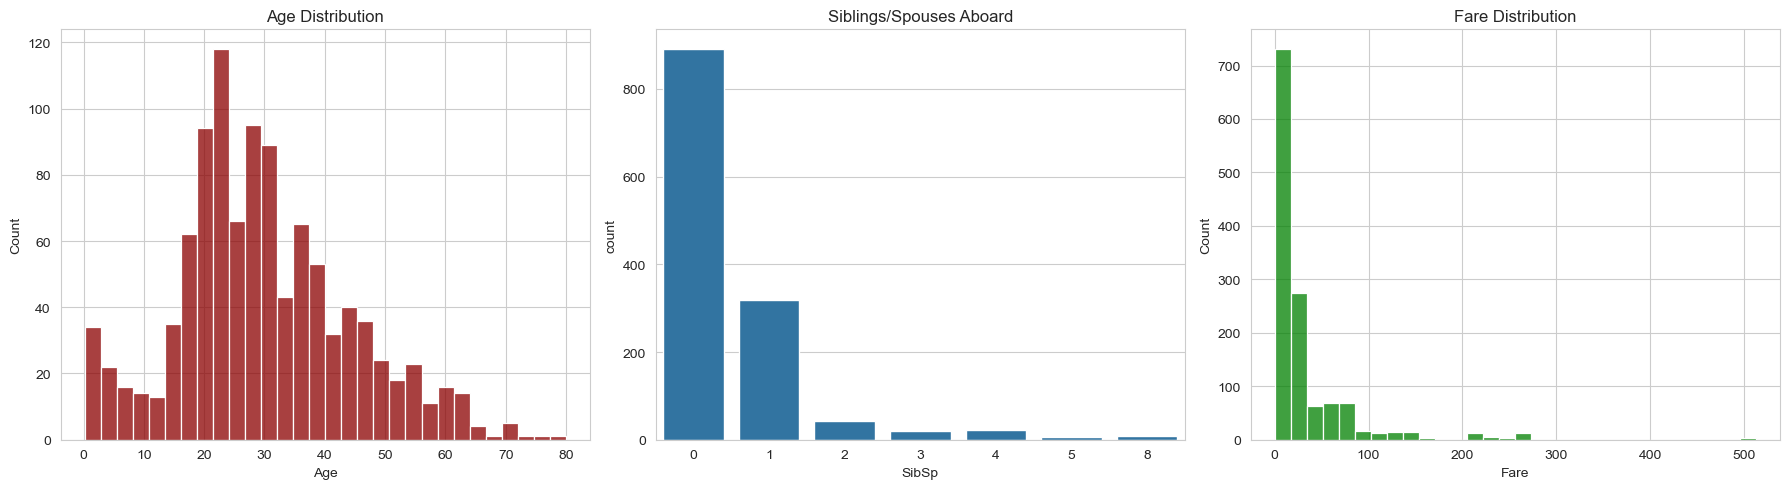

In [90]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age distribution
sns.histplot(df["Age"].dropna(), bins=30, kde=False, color="darkred", ax=axes[0])
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')

# Siblings/Spouses aboard
sns.countplot(x="SibSp", data=df, ax=axes[1])
axes[1].set_title('Siblings/Spouses Aboard')
axes[1].set_xlabel('SibSp')

# Fare distribution
sns.histplot(df["Fare"], bins=30, kde=False, color="green", ax=axes[2])
axes[2].set_title('Fare Distribution')
axes[2].set_xlabel('Fare')

plt.tight_layout()
plt.show()

**Insights:**
- Women had higher survival rates.

- Wealthier passengers (Pclass 1) were more likely to survive.

- Most passengers were young adults, but survival wasn’t uniform across ages.

## 3. Data Cleaning

### 3.1 Imputing Missing Age Values
**Instead of filling missing ages with the overall mean, we can use passenger class as a proxy: wealthier passengers tended to be older.**

/var/folders/7s/0rcqb3qx23q58vkkkt44m9hc0000gn/T/ipykernel_7275/889629956.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Pclass", y="Age", data=train, palette="winter", ax=ax)


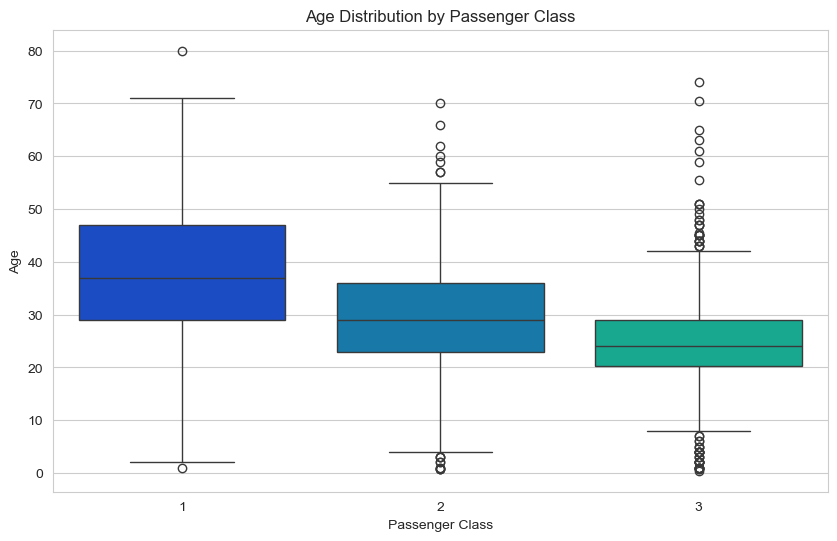

In [91]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x="Pclass", y="Age", data=train, palette="winter", ax=ax)
ax.set_title('Age Distribution by Passenger Class')
ax.set_xlabel('Passenger Class')
ax.set_ylabel('Age')
plt.show()

**The Strategy for Age Imputation Using Class-Based Medians**
We're using median ages within each passenger class to fill missing Age values. This approach is statistically robust because median is representative of the "typical" passenger in each class. 



In [92]:
# We'll use this function independently on both the training and testing datasets 
# to fill in missing Age values. 
# It's important to keep them separate to avoid leaking information from the test set into training.

def impute_age(cols):
    Age, Pclass = cols
    if pd.isnull(Age):
        if Pclass == 1:
            return df[df['Pclass']==1]['Age'].median()
        elif Pclass == 2:
            return df[df['Pclass']==1]['Age'].median()
        else:
            return df[df['Pclass']==1]['Age'].median()
    else:
        return Age

# train["Age"] = train[["Age", "Pclass"]].apply(impute_age, axis=1)


### 3.2 Dropping Unnecessary Columns

- Cabin: Too many missing values.

- Name & Ticket: Text-heavy, not very informative at this stage.

- Embarked: Drop missing rows (only a few).

In [93]:
df_clean = df.copy()
df_clean.drop(["Cabin", "Name", "Ticket"], axis=1, inplace=True)
df_clean.dropna(inplace=True)

### 3.3 Converting Categorical Variables
**Machine learning models require numerical input. We’ll use dummy variables for categorical features:**

In [94]:
# Convert categorical to dummy variables
# When you have 3 categories (C, Q, S), you only need 2 dummy columns because the third can be inferred.
sex = pd.get_dummies(df_clean["Sex"], drop_first=True)
embark = pd.get_dummies(df_clean["Embarked"], drop_first=True)

# Drop old columns and add dummies
df_clean.drop(["Sex", "Embarked"], axis=1, inplace=True)
df_clean = pd.concat([df_clean, sex, embark], axis=1)

df_clean.head()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0.0,3,22.0,1,0,7.2500,True,False,True
1,2,1.0,1,38.0,1,0,71.2833,False,False,False
2,3,1.0,3,26.0,0,0,7.9250,False,False,True
3,4,1.0,1,35.0,1,0,53.1000,False,False,True
4,5,0.0,3,35.0,0,0,8.0500,True,False,True


## 4. Building the Logistic Regression Model

### 4.1 Train-Test Split

**We’ll split the data into training (70%) and testing (30%) sets.**

In [95]:
from sklearn.model_selection import train_test_split

X = df_clean.drop("Survived", axis=1)
y = df_clean["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101
)


### 4.2 Training the Model

In [96]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(max_iter=200)
logmodel.fit(X_train, y_train)


/Users/saeedrezaee/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

### 4.3 Making Predictions

In [97]:
predictions = logmodel.predict(X_test)


## 5.Model Evaluation in Detail

**Once we’ve trained our Logistic Regression model and made predictions, the next step is to evaluate its performance.**
**Since this is a binary classification problem (Survived = 0 or 1), there are multiple metrics we can use:**

- Accuracy: Proportion of correct predictions.

- Confusion Matrix: Shows true positives, false positives, true negatives, and false negatives.

- Precision: Of all passengers we predicted as "Survived," how many actually survived?

- Recall (Sensitivity): Of all passengers who truly survived, how many did we correctly identify?

- F1-Score: Harmonic mean of precision and recall.

- ROC Curve and AUC: Evaluates performance across different thresholds, not just one.



### 5.1 Accuracy

In [99]:
from sklearn.metrics import accuracy_score

# Accuracy = correct predictions / total predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.7897


**Interpretation: Accuracy tells us how often the model is right overall, but it can be misleading if the classes are imbalanced.**

### 5.2 Confusion Matrix

Confusion Matrix:
 [[107  21]
 [ 24  62]]


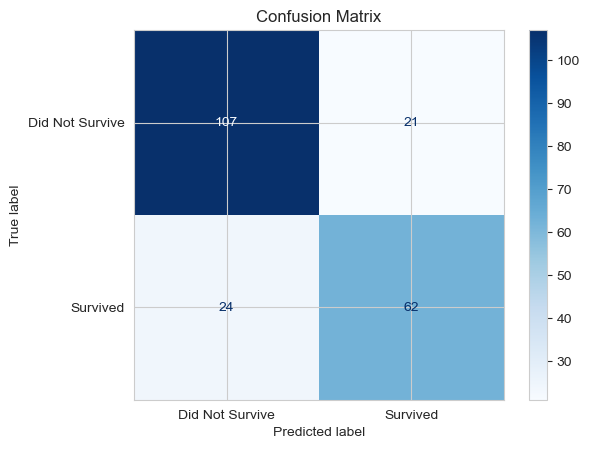

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display as numbers
print("Confusion Matrix:\n", cm)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


**Interpretation of confusion matrix:**

- True Negative (TN): Model predicted 0, actual was 0 (correctly predicted death).

- False Positive (FP): Model predicted 1, actual was 0 (incorrectly predicted survival).

- False Negative (FN): Model predicted 0, actual was 1 (missed a survivor).

- True Positive (TP): Model predicted 1, actual was 1 (correctly predicted survival).

### 5.3 Precision, Recall, F1-Score

In [101]:
from sklearn.metrics import classification_report

# Generate detailed classification report
report = classification_report(y_test, predictions, target_names=["Did Not Survive", "Survived"])
print(report)


                 precision    recall  f1-score   support

Did Not Survive       0.82      0.84      0.83       128
       Survived       0.75      0.72      0.73        86

       accuracy                           0.79       214
      macro avg       0.78      0.78      0.78       214
   weighted avg       0.79      0.79      0.79       214



**Interpretation:**

- Precision (for Survived=1) → If the model predicts someone survived, how often is it correct?

- Recall (for Survived=1) → Of all actual survivors, how many did the model catch?

- F1-Score → Balance between precision and recall.

### 5.4 ROC Curve and AUC
**The ROC (Receiver Operating Characteristic) curve plots True Positive Rate (Recall) vs False Positive Rate, showing how the model performs at different classification thresholds.**

AUC Score: 0.8373


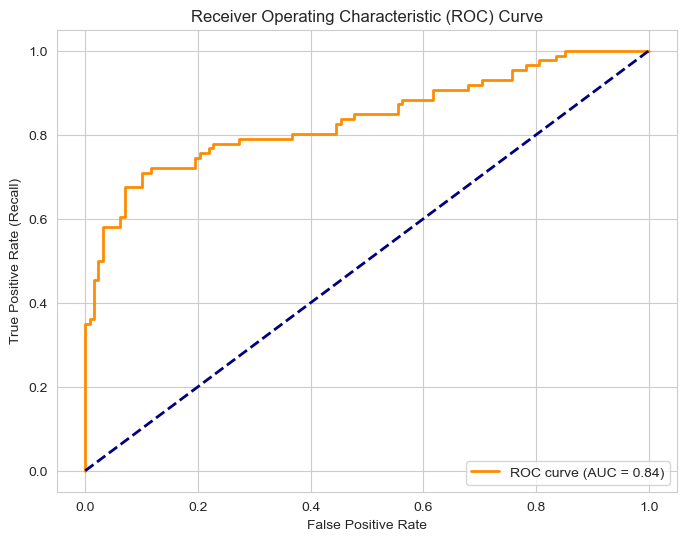

In [102]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get probability estimates instead of just predictions
y_prob = logmodel.predict_proba(X_test)[:,1]  # Probability of Survived=1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.4f}")

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


**Interpretation:**

- AUC (Area Under Curve) ranges from 0.5 (random guessing) to 1.0 (perfect model).

- Higher AUC = better model performance.

## 6. Next Steps: 
**The logistic regression gives a good baseline, but performance can be improved with feature engineering. Some ideas:**

- Extract titles (Mr., Mrs., Dr., etc.) from passenger names.

- Use Cabin letters (A, B, C…) instead of dropping the column entirely.

- Explore ticket prefixes for potential groupings.

- Try different algorithms (Random Forests, Gradient Boosting, etc.).